In [1]:
import os
import cv2
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad

%matplotlib inline

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Image Paths

In [3]:
training_images = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/Dataset/1.training/1.training'
training_pseudo_labels = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/Dataset/1.training/1.training_pseudo_labels'

cutmix_images = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/Dataset/cutmix_augmentation'
cutmix_pseudo_labels = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/Dataset/cutmix_augmentation_pseudo_labels'

bordered_images = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/data_border_constant'
bordered_pseudo_labels = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/data_border_constant_pseudo_labels'

reflected_images = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/data_border_reflect'
reflected_pseudo_labels = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/data_border_reflect_pseudo_labels'

In [4]:
def preprocess_image(img: np.ndarray, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize(mean, std),
                                      ])
  return preprocessing(img.copy()).unsqueeze(0)


In [5]:
def reshape_transform(tensor, height=14, width=14):
  result = tensor[:, 1 :  , :].reshape(tensor.size(0),
                                       height, width, tensor.size(2))
  
  # Bring the channels to the first dimension,
  # like in CNNs.
  result = result.transpose(2, 3).transpose(1, 2)
  return result

# Setting up model for pseudo label generation

In [6]:
model_vit_base_patch16_224 = timm.create_model('vit_base_patch16_224', pretrained = True, num_classes = 3,
                                               drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

model_vit_base_patch16_224.load_state_dict(torch.load(f='/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch16_224_1.pth', map_location=device))

<All keys matched successfully>

In [7]:
target_layer = [model_vit_base_patch16_224.blocks[-1].norm1]
target_layer

[LayerNorm((768,), eps=1e-06, elementwise_affine=True)]

In [8]:
cam = GradCAM(model = model_vit_base_patch16_224, target_layers=target_layer, reshape_transform=reshape_transform)

# Function to load images, create pseudo labels, and save them to the location

In [22]:
# function that loads images from a directory generates cam for them and saves them to a directory
def generate_pseudo_labels(images_dir, pseudo_labels_dir, model):
    for image_name in tqdm(os.listdir(images_dir)):
        image_path = os.path.join(images_dir, image_name)
        image = cv2.resize(cv2.imread(image_path), (224, 224))
        image = preprocess_image(image)
        image = image.to(device)
        #print(image_name)
        label = list(map(int, image_name[-13:-4].strip('][').split(', ')))
        
        pseudo_label = np.zeros((224, 224, 3))
        
        cam_0 = cam(input_tensor=image, targets=[ClassifierOutputTarget(np.array([0]))])[0, :]
        if label[0] == 1:
            pseudo_label[:, :, 0] = mask_threshold(cam_0)
        cam_1 = cam(input_tensor=image, targets=[ClassifierOutputTarget(np.array([1]))])[0, :]
        if label[1] == 1:
            pseudo_label[:, :, 1] = mask_threshold(cam_1)
        cam_2 = cam(input_tensor=image, targets=[ClassifierOutputTarget(np.array([2]))])[0, :]
        if label[2] == 1:
            pseudo_label[:, :, 2] = mask_threshold(cam_2)
        
        pseudo_label_path = os.path.join(pseudo_labels_dir, image_name)
        pseudo_label = pseudo_label
        
        cv2.imwrite(os.path.join(pseudo_labels_dir, image_name), pseudo_label*255)    # on loading the mask from the directory, normalize by dividing by 255 to get binary mask
        #print(f'{image_name} done')

In [22]:
def mask_threshold(mask):
    v = np.concatenate(mask)
    t = v.mean()
    d = np.inf
    ds = 0.005
    while d > ds:
        g1 = v[v>t]
        g2 = v[v<=t]
        m1 = g1.mean()
        m2 = g2.mean()
        tp = (m1 + m2)/2
        d = np.abs(t - tp)
        t = tp
        #print(t)

    imt = mask > t

    return imt

In [25]:
generate_pseudo_labels(bordered_images, bordered_pseudo_labels, model_vit_base_patch16_224, cam)

  0%|          | 0/10091 [00:00<?, ?it/s]

1222870-17531-5689-[0, 0, 1].png


In [9]:
image_names = os.listdir(training_images)

In [13]:
img = image_names[np.random.randint(0, len(image_names))]
img

'TCGA-99-7458-01A-01-BS1-9748-11548-[1, 1, 0].png'

In [23]:
image_path = os.path.join(training_images, img)
image = cv2.resize(cv2.imread(image_path), (224, 224))
image = preprocess_image(image)
image = image.to(device)
#print(image_name)
label = list(map(int, img[-13:-4].strip('][').split(', ')))
print(label)

pseudo_label = np.zeros((224, 224, 3))

cam_0 = cam(input_tensor=image, targets=[ClassifierOutputTarget(np.array([0]))])[0, :]
if label[0] == 1:
    pseudo_label[:, :, 0] = mask_threshold(cam_0)
cam_1 = cam(input_tensor=image, targets=[ClassifierOutputTarget(np.array([1]))])[0, :]
if label[1] == 1:
    pseudo_label[:, :, 1] = mask_threshold(cam_1)
cam_2 = cam(input_tensor=image, targets=[ClassifierOutputTarget(np.array([2]))])[0, :]
if label[2] == 1:
    pseudo_label[:, :, 2] = mask_threshold(cam_2)

#pseudo_label_path = os.path.join(pseudo_labels_dir, image_name)
pseudo_label = pseudo_label

[1, 1, 0]


/tmp/ipykernel_6655/3965795295.py:9: RuntimeWarning: Mean of empty slice.
  m1 = g1.mean()
/home/zephyr/.local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


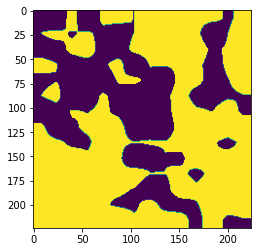

In [24]:
plt.imshow(mask_threshold(cam_0))